In [38]:
from qat.lang.AQASM import QRoutine

# Solving Sudoku with Grover's Algorithm  
This notebook dives into using Grover's algorithm to solve the classic puzzle game, Sudoku.  
It aims to predominantly take a Computer Science approach to Quantum Computing in order to make the topic more accessible to a broader public.  
## Grover's Algorithm  
Grover's algorithm is based on two key components (Oracle and Diffusor)
* ### Oracle
  Given a solution state $|w\rangle$ the oracle 'Marks' the solution state by introducing a phase flip to that specific state
$$
U_w|x\rangle = \left\{ 
\begin{array}{ll}
|x\rangle & \text{if } x \neq w \\
-|x\rangle & \text{if } x = w 
\end{array}
\right.
$$
* ### Diffusor - Diffusion Operator
  The Diffusor aims to amplify the amplitude of the solution state to increase the probability of the solution being measured at the end
  => $D = 2|s\rangle\langle s| - I$

## Classical Calculations  
Before starting with the quantum algorithm the Constraints of the sudoku are calculated  
##### emptyCellConstraints
Here the constraints between empty cells are calculated  
* (1,0) => Empty Cell at #1 cant be the same as empty Cell at #0
* These edges are stored to later check them with the equality oracle
##### startingNumberConstraints  
Here the Number Constraints of the empty cells are defined => All the numbers the emptyCells are not allowed to be
* (0,1) => Empty cell 0 cant have value 1
* These Constraints have to be encoded into the Superposition of the color qubits using amplitudes
##### emptySquares  
Here the position of the empty cells is defined

In [39]:
import SudokuQuantum as sq

solver = sq.SudokuSolver()

sudokuBoard4_5 = [
    [0,0,3,4],
    [0,0,1,0], #2
    [2,3,4,1], 
    [4,1,2,3]  
]

# Select here which board to check
board = sudokuBoard4_5
board_size = len(board[0])
print(f"Boardsize: {board_size}")
emptyCellConstraints, startingNumberConstraints, emptySquares = solver.FindEdgesAndNumberConstraints(board, board_size)

# The Empty Square Edges specifies the constraints between the empty edges 
# (1,0) => Empty Cell #1 cant be the same as empty Cell #0
print(f"EmptyCellConstraints: {emptyCellConstraints}")

# The Number Constraints 
# (0,1) => Empty Cell 0 cant have value 1
print(f"NumberConstraints: {startingNumberConstraints}")

# This Holds the position of the empty cells
emptyCellCount = len(emptySquares)
print(f"EmptySquaresCount: {emptyCellCount} , EmpySquaresPos: {emptySquares}")

# Bits needed to represent all "colors" 
bits_needed = 2 if board_size.bit_length() == 3 else 3
print(f"Bits needed to represent all colors: {bits_needed}")

Boardsize: 4
EmptyCellConstraints: [(1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3)]
NumberConstraints: {(0, 1), (1, 2), (4, 0), (2, 1), (4, 3), (0, 3), (2, 0), (4, 2), (3, 0), (2, 3), (0, 2), (1, 0), (3, 2), (1, 3)}
EmptySquaresCount: 5 , EmpySquaresPos: [(Row: 0; IndexInRow: 0), (Row: 0; IndexInRow: 1), (Row: 1; IndexInRow: 0), (Row: 1; IndexInRow: 1), (Row: 1; IndexInRow: 3)]
Bits needed to represent all colors: 2


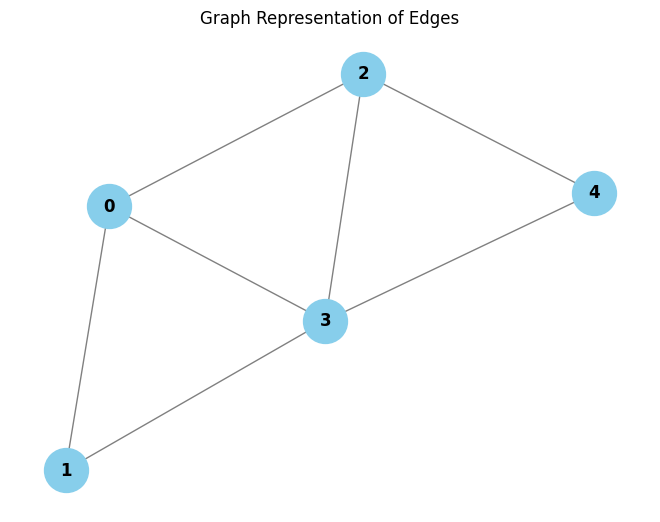

In [40]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph
G = nx.Graph()

# List of edges
edges = emptyCellConstraints

# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph
pos = nx.spring_layout(G)  # Use spring layout for positioning nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color='gray', font_weight='bold')

# Show the graph using matplotlib
plt.title("Graph Representation of Edges")
plt.show()

#### Time Complexity
For $m =$ number Of Possibilities in each square and For $n =$ boardsize  
Classical Time Complexity for finding the constraints is $O(n^2)$  
Classical Time Complexity for finding the solution is $O(m^{n})$    
Quantum Time Complexity for finding the solution is $O(\sqrt{n})$

## Oracle  
The Oracle's primary function is to invert the phase of the solution state $|w\rangle$   
To do this we first need to define what the solution state $|w\rangle$ is  
For simplification purposes we are going to look only at a 4x4 Sudoku with 4 missing numbers. 0 represents missing numbers.   
**[0,0,3,4]  
[0,0,1,2]  
[2,3,4,1]  
[4,1,2,3]**  
To solve this problem we can translate the sudoku problem into a graph coloring problem where every empty cell is a node $c(i)$ on the graph with constraints that are defined by the sudoku rules. For the above 4x4 sudoku we would get emptyCellConstraints = [(1, 0), (2, 0), (3, 0), (3, 1), (3, 2)] 
  
This comparison is the same as a color comparison of two nodes. We can visualize the above constraints like this: 

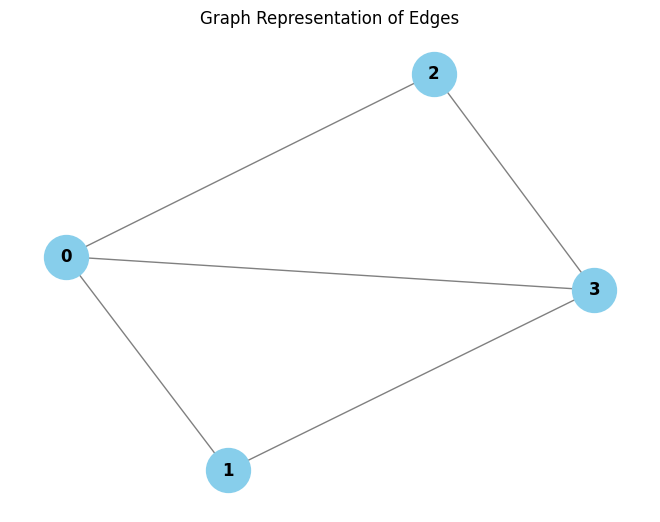

* =>The state where all constraints are met is the solution state. => When all empty cells are filled with correct numbers and no sudoku constraints are violated we have the solution state
 
### Representing cells  
The cells in a 4x4 Sudoku can take the values from 1 to 4.   
2 Bits would be able to represent all the possible states for one cell  
[00 - 1] + [01 - 2] + [10 - 3] + [11 - 4]  
If we were to increase the Sudoku size it would be sufficient to just increase the bit amount in order to store all possible states.  
### Checking cells
To check that no constraint is violated we need to check every single constraint for the empty cells. $c_i≠c_j$  
We can do this by
1. Applying CNOT on two cells
    + Checks if qubits in cell0 are equal to cell1 
    + Example1:  $c_0 |11\rangle$  $c_1 |01\rangle$ [CNOT]=>  $c_0 |11\rangle$  $c_1 |10\rangle$
    + Example2:  $c_0 |11\rangle$  $c_1 |11\rangle$ [CNOT]=>  $c_0 |11\rangle$  $c_1 |00\rangle$
    => If cells are the same the second cell will always be in the $|00\rangle$ state
3. Applying X Gate
    + Example1:  $c_1 |10\rangle$ [x]=> $c_1 |01\rangle$
    + Example2:  $c_1 |00\rangle$ [x]=> $c_1 |11\rangle$
   => If cell1 is in $|00\rangle$ state (only if $c_0=c_1$)    it will be flipped to $|11\rangle$
4. Applying Multi-Controlled X Gate
    + Checking if cell1 is in $|1\rangle$ state, if yes flip output bit
    + Example1: $c_1 |10\rangle$ and Output $|0\rangle$ [Multi-Controlled X]=> Output $|0\rangle$
    + Example2: $c_1 |11\rangle$ and Output $|0\rangle$ [Multi-Controlled X]=> Output $|1\rangle$

If the output qubit is $|1\rangle$ then the two cells are the same  
If it is $|0\rangle$ then they are not the same
Lets write a routine that represents this single edge check

In [41]:
from qat.lang.AQASM import QRoutine, Z, H, X, CNOT
from qat.lang.AQASM.misc import build_gate

@build_gate("Check_Edge", [int], arity=lambda m: 2*m + 1)
def check_edge(m):
    rout = QRoutine()
    #cell1 equals to the first m wires
    cell0 = rout.new_wires(m)
    #cell2 equals to the m wires after that
    cell1 = rout.new_wires(m)
    #output is equal to the single last wire and is used to store the information of the comparison
    output = rout.new_wires(1)
    with rout.compute():
        
        for wire1,wire2 in zip(cell0, cell1):
            #Applying CNOT on two cells
            CNOT(wire1, wire2)
        for wire in cell1:
            X(wire)
    #Multi Controlled NOT gate
    #m for how many control qbits
    #color2 are the control qubits
    #output is the target qubit
    #The X gate is applied to the output qubit only if all color2 qubits are in state |1⟩
    X.ctrl(m)(cell1, output)
    rout.uncompute()
    X(output)
    return rout
    
example = check_edge(2)
example.display()

Now that we have a single edge routine check we can write a check for all edges.

In [42]:
# Workaround for build_gate decorator signature
# @build_gate Decorator does not allow for 2d lists
# We create an class and pass an object that holds the List
class EmptyCellConstraintHolder:
    def __init__(self, constraints):
        self.constraints = constraints

ch = EmptyCellConstraintHolder(emptyCellConstraints)

print(ch.constraints)

[(1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3)]


In [43]:
from qat.lang.AQASM.qftarith import add
@build_gate('Oracle',[int,EmptyCellConstraintHolder,int],arity=lambda n, e, m:n * m)
def sudokuOracle(Nodes: int, constraintsHolder, m: int):
    rout = QRoutine()
    
    # Get the emptyCellConstraints stored in the constraintsHolder object
    edges = constraintsHolder.constraints
    
    # Array to store all colors (register)
    colors = [rout.new_wires(m) for node in range(Nodes)]
    
    conflictEdges = len(edges)
    # We are looking for a solution that has no edge with same color at both ends
    # Every edge has to be compared to check that the condition to not be the same color/number is not violated
    # The result for every operation is safed on one qubit => len(edges) for the amount of qubits
    edgeConflictQubits = rout.new_wires(conflictEdges)
    
    # Then for all edges the state is checked on the output qubit
    output = rout.new_wires(1)
    
    # Initialize the check_routine with m = 2
    check_routine = check_edge(bits_needed)
    
    # Create an Adder
    adder = add(1,1)
    with rout.compute():
        for (start, end), conflictQubit in zip(edges, edgeConflictQubits):
            
            with rout.compute():
                check_routine(colors[start], colors[end], conflictQubit)
                
            rout.uncompute()
        
    # Check the state of all edgeConflictQubits
    Z.ctrl(len(edges))(edgeConflictQubits, output)
    
    rout.uncompute()
    
    rout.set_ancillae(edgeConflictQubits ,output)
    
    return rout

## Diffusion Operator  
Prerequisite: $|amplitudes| = probability$  
Imagine all possible solutions in Grover's algorithm as vectors with associated amplitudes.  
While the Oracle marks the correcdt solution by inverting its phase. The Diffusor's role is to amplify the probability of measuring this solution.  
This works by amplifying all signed states

In [44]:
@build_gate("Diffusor", [int], arity=lambda n: n)
def diffusion(nqbits):
    rout = QRoutine()
    wires = rout.new_wires(nqbits)
    with rout.compute():
        for wire in wires:
            H(wire)
            X(wire)
    Z.ctrl(nqbits-1)(wires)
    rout.uncompute()
    return rout

example = diffusion(4)
example.display()

## Allowed Amplitudes  
After using the emptyCellConstraints with the oracle, we are still left with the startingNumberConstraints  


In [45]:
import numpy as np
# This function returns a 4x4 matrix of the allowed amplitudes for the 4 given Qubits
# I.E. :
#     [1, 0, 0, 0],  # 00
#     [0, 1, 0, 0],  # 01
#     [0, 0, 1, 0],  # 10
#     [0, 0, 0, 1],  # 11

def AllowedAmplitudes(Nodes, m ,startingNumberConstraints):
    amplitudes = np.ones((Nodes, 2**m))
    print(f'Before Constraints: \n{amplitudes}')
    for cell, value in startingNumberConstraints:
        if value <= 8:
            try:
                amplitudes[cell, value] = 0
            except IndexError:
                print(f"Error setting amplitude for cell {cell} and value {value}.")
    print(f'After Constraints: \n{amplitudes}')
    return amplitudes

amps = AllowedAmplitudes(Nodes = emptyCellCount, m = bits_needed, startingNumberConstraints = startingNumberConstraints)

Before Constraints: 
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
After Constraints: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 0.]]


## Gate for encoding Amplitudes  
We will initialize the Qubits with the AllowedAmplitudes using an AbstractGate that manipulates the amplitudes of the given Qubits  
+ First we will need a Variable Matrix that depends on how many amplitudes are given


In [46]:
from qat.lang.AQASM import AbstractGate, Program
from qat.qpus import get_default_qpu

def prep_var_matrix(*amps):
    zeros = [0] * (len(amps)-1)
    matrix = []
    for amp in amps:
        matrix.append([amp] + zeros)
    print(f'PrepMatrix: {matrix}')
    return np.array([matrix])

PREP = AbstractGate('PREP',[float]*(2**bits_needed), arity=bits_needed, matrix_generator=prep_var_matrix)

prog = Program()

qubits = prog.qalloc(bits_needed)
chunk = qubits[0:2]

amp = 1/np.sqrt(2)

prog.apply(PREP(0,amp,0,amp), *chunk)

# PREP(0, amp, 0, amp)(qubits[0], qubits[1])

job = prog.to_circ().to_job()

qpu = get_default_qpu()

result = qpu.submit(job)

for res in result:
    print(f"State: {res.state}, Probability: {res.probability}, Amplitude: {res.amplitude}")


PrepMatrix: [[0, 0, 0, 0], [0.7071067811865475, 0, 0, 0], [0, 0, 0, 0], [0.7071067811865475, 0, 0, 0]]
State: |01>, Probability: 0.4999999999999999, Amplitude: (0.7071067811865475+0j)
State: |11>, Probability: 0.4999999999999999, Amplitude: (0.7071067811865475+0j)


## Prepare Superposition

In [47]:
@build_gate("PrepState", [int, int, set], arity=lambda n, m, constraints: n*m)
def prepareSuperposition(Nodes, m, CellConstraints):
    rout = QRoutine()

    # Array to store all colors (register)
    colors = [rout.new_wires(m) for node in range(Nodes)]
    
    # Get the allowed Amplitudes after taking startingNumberConstraints into Account
    amplitudes = AllowedAmplitudes(Nodes = Nodes,m = m ,startingNumberConstraints = CellConstraints)
    amp = 1/np.sqrt(2)
    
    amps = [[1/np.sqrt(np.sum(row)) if value == 1 else 0 for value in row] for row in amplitudes]
    print(f'Amplitudes: {amplitudes}')
    print(f'EncodedAmps: {amps}')
    num_columns = amplitudes.shape[1]  
    # For each Cell prepare Superposition of its possible states on the qubits storing its color
    for (amps, chunk) in zip(amps, colors):
        print(f'AmpsInLoop: {amps}')
        rout.apply(PREP(*amps), *chunk)
        # encodeAmplitudes(amplitudes, chunk)

    return rout

## Apply the Grover Algorithm

In [48]:
from qat.lang.AQASM.qint import QInt
def SudokuGrover(Nodes, m, iterations):
    prog = Program()

    # Create the qubits for every node
    data = [prog.qalloc(m, QInt) for _ in range(Nodes)]

    # Initialize the Superposition
    prepState = prepareSuperposition(Nodes, m, startingNumberConstraints)

    # Apply the oracle
    oracle = sudokuOracle(Nodes, ch, m)

    # Apply the diffusor
    diffusor = diffusion(Nodes*m)

    prepState(data)

    for _ in range(iterations):
        oracle(data)
        diffusor(data)
        
        

    return prog.to_circ(), data

## Run the Grover Algorithm

In [49]:
circ, reg = SudokuGrover(Nodes = emptyCellCount,m = bits_needed,iterations = 1)
print(f"Using: {np.size(reg)} qubits")
dir(reg)
qpu = get_default_qpu()

result = qpu.submit(circ.to_job(qubits = reg))

for res in result:
    print(f"State: {res.state}, Probability: {res.probability}, Amplitude: {res.amplitude}")

for nbsteps in range(2, 8):
    result = qpu.submit(circ.to_job(qubits=reg))
    color, reg = SudokuGrover(Nodes = emptyCellCount, m =  bits_needed, iterations = nbsteps)
    success_proba = 0
    for sample in result:
        colors = sample.state.value
        if all(colors[a] != colors[b] for a, b in ch.constraints):
            success_proba += sample.probability
    print(f'Nbsteps: {nbsteps}, Success_proba: {success_proba}')

Before Constraints: 
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
After Constraints: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 0.]]
Amplitudes: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 0.]]
EncodedAmps: [[1.0, 0, 0, 0], [0, 1.0, 0, 0], [0, 0, 1.0, 0], [0, 0.7071067811865475, 0, 0.7071067811865475], [0, 1.0, 0, 0]]
AmpsInLoop: [1.0, 0, 0, 0]
AmpsInLoop: [0, 1.0, 0, 0]
AmpsInLoop: [0, 0, 1.0, 0]
AmpsInLoop: [0, 0.7071067811865475, 0, 0.7071067811865475]
AmpsInLoop: [0, 1.0, 0, 0]
PrepMatrix: [[1.0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
PrepMatrix: [[0, 0, 0, 0], [1.0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
PrepMatrix: [[0, 0, 0, 0], [0, 0, 0, 0], [1.0, 0, 0, 0], [0, 0, 0, 0]]
PrepMatrix: [[0, 0, 0, 0], [0.7071067811865475, 0, 0, 0], [0, 0, 0, 0], [0.7071067811865475, 0, 0, 0]]
Using: 10 qubits
State: |0>|0>|0>|0>|0>, Probability: 7.629394531249975e-06, Amplitude: None
State: |0>|0>|0>|

In [50]:
def single_search(Nodes, m, nbsteps):
    grover, registers = SudokuGrover(Nodes, m, nbsteps)
    job = grover.to_job(qubits=registers, nbshots=1)
    result = qpu.submit(job)
    for res in result:
        print(f" state: {res.state}, amplitude: {res.amplitude}, probability: {res.probability}")
    return result[0].state.value 

In [51]:
def q_search(m):
    l = 1
    c = 1.5
    M = int(np.ceil(c ** l))
    while True:
        j = np.random.randint(1, M)
        print("Trying with", j, "steps")
        coloration = single_search(Nodes = emptyCellCount,m = m,nbsteps = j)
        if all(coloration[a] != coloration[b] for a, b in ch.constraints):
            return coloration
        l += 1
        M = int(np.ceil(c ** l))

In [52]:
coloration = q_search(bits_needed)
print("Found a valid coloration:", coloration)

Trying with 1 steps
Before Constraints: 
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
After Constraints: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 0.]]
Amplitudes: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 0.]]
EncodedAmps: [[1.0, 0, 0, 0], [0, 1.0, 0, 0], [0, 0, 1.0, 0], [0, 0.7071067811865475, 0, 0.7071067811865475], [0, 1.0, 0, 0]]
AmpsInLoop: [1.0, 0, 0, 0]
AmpsInLoop: [0, 1.0, 0, 0]
AmpsInLoop: [0, 0, 1.0, 0]
AmpsInLoop: [0, 0.7071067811865475, 0, 0.7071067811865475]
AmpsInLoop: [0, 1.0, 0, 0]
PrepMatrix: [[1.0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
PrepMatrix: [[0, 0, 0, 0], [1.0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
PrepMatrix: [[0, 0, 0, 0], [0, 0, 0, 0], [1.0, 0, 0, 0], [0, 0, 0, 0]]
PrepMatrix: [[0, 0, 0, 0], [0.7071067811865475, 0, 0, 0], [0, 0, 0, 0], [0.7071067811865475, 0, 0, 0]]
 state: |0>|1>|2>|3>|1>, amplitude: None, probability: 1.0
Found a valid coloration: (0, 1

In [53]:
import networkx as nx
# we need an adder:
from qat.lang.AQASM.qftarith import add

@build_gate("CHECK_GRAPH", [nx.Graph, int], arity=lambda g, m: g.number_of_nodes() * m)
def check_graph(graph, m):
    rout = QRoutine()
    # Colors array
    colors = [rout.new_wires(m) for _ in graph.nodes()]
    # Our counter L
    size_l = graph.number_of_edges().bit_length()
    L = rout.new_wires(size_l)
    # a work qubit to store the result of a check_edge
    tmp = rout.new_wires(1)
    # some routines (check_edge and an adder)
    check_routine = check_edge(m)
    adder = add(size_l, 1)
    with rout.compute():
        for a, b in graph.edges():
            # checking the edge
            with rout.compute():
                check_routine(colors[a], colors[b], tmp)
            # adding the result in our counter
            adder(L, tmp)
            # uncomputing 'tmp'
            rout.uncompute()
    # checking if l = |E|
    E = graph.number_of_edges()
    with rout.compute():
        for i in range(size_l):
            if ((E >> i) & 1) == 0:
                X(L[i])
    Z.ctrl(size_l - 1)(L)
    # uncomputing the X's
    rout.uncompute()
    # uncomputing L
    rout.uncompute()
    # tmp and L are work qubits and should be flagged to that they can be re-used
    rout.set_ancillae(L, tmp)
    return rout
    
graph = nx.generators.path_graph(3)
example = check_graph(graph, 2)

example.display()
example.display(depth=2)